In [3]:
# import all the necessary libs
import numpy as np
import pandas as pd
import re
import os
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import Conv1D, GlobalMaxPooling1D, Embedding, Merge, Dropout, LSTM, GRU, Bidirectional
from keras.models import Sequential, Model
from keras.models import model_from_json

In [24]:
def clean_up(string):
    """
    get rid of some useless '\' and make sure all the text is lower case
    """
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()
def get_word_embedding(DIR):    
    d = {}
    f = open(DIR)
    for line in f:
        v = line.split()
        word = v[0]
        vec = np.asarray(v[1:], dtype='float32')
        d[word] = vec
    f.close()
    return d

In [27]:
#### changable parameters
MAX_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
DATA_DIR = '/Volumes/Dragon/Sentiment_Analysis/labeledTrainData.tsv'
training_data = pd.read_csv(DATA_DIR, sep='\t')
GLOVE_DIR = "/Volumes/Dragon/Sentiment_Analysis/Glove/glove.6B/glove.6B.100d.txt"


In [28]:
#### clean up the string
texts = []
labels = []
for i in range(training_data.review.shape[0]):
    text = BeautifulSoup(training_data.review[i], "lxml")
    texts.append(clean_up(text.get_text()))
    labels.append(training_data.sentiment[i])
print(len(texts),len(labels))

25000 25000


In [29]:
#### word representation   
word_embeddings = get_word_embedding(GLOVE_DIR)
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', len(texts))
print('Shape of label tensor:', len(labels))
print('Total %s word vectors.' % len(word_embeddings))

Shape of data tensor: 25000
Shape of label tensor: 25000
Total 400000 word vectors.


In [30]:
#### transfer to sequence
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=MAX_LENGTH)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [31]:
len(word_index)

81501

In [32]:
# split the dataset
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [33]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = word_embeddings.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
print ('Length of embedding_matrix:', embedding_matrix.shape[0])
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            mask_zero=False,
                            input_length=MAX_LENGTH,
                            trainable=False)

print('Traing and validation set number of positive and negative reviews')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))

Length of embedding_matrix: 81502
Traing and validation set number of positive and negative reviews
[  9989.  10011.]
[ 2511.  2489.]


In [34]:
#### computation graph
sequence_input = Input(shape=(MAX_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
dense_1 = Dense(100,activation='tanh')(embedded_sequences)
max_pooling = GlobalMaxPooling1D()(dense_1)
dense_2 = Dense(2, activation='softmax')(max_pooling)


In [35]:
model = Model(sequence_input, dense_2)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1000, 100)         8150200   
_________________________________________________________________
dense_3 (Dense)              (None, 1000, 100)         10100     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 202       
Total params: 8,160,502
Trainable params: 10,302
Non-trainable params: 8,150,200
_________________________________________________________________


In [37]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=10, batch_size=50)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 201s 10ms/step - loss: 0.5607 - acc: 0.7211 - val_loss: 0.4500 - val_acc: 0.8146
Epoch 2/10
20000/20000 [==============================] - 197s 10ms/step - loss: 0.4090 - acc: 0.8269 - val_loss: 0.3930 - val_acc: 0.8346
Epoch 3/10
20000/20000 [==============================] - 195s 10ms/step - loss: 0.3549 - acc: 0.8515 - val_loss: 0.3630 - val_acc: 0.8478
Epoch 4/10
20000/20000 [==============================] - 194s 10ms/step - loss: 0.3232 - acc: 0.8690 - val_loss: 0.3479 - val_acc: 0.8558
Epoch 5/10
20000/20000 [==============================] - 195s 10ms/step - loss: 0.3000 - acc: 0.8785 - val_loss: 0.3514 - val_acc: 0.8592
Epoch 6/10
20000/20000 [==============================] - 194s 10ms/step - loss: 0.2797 - acc: 0.8889 - val_loss: 0.3378 - val_acc: 0.8632
Epoch 7/10
20000/20000 [==============================] - 196s 10ms/step - loss: 0.2612 - acc: 0.8987 - val_loss: 0.3

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


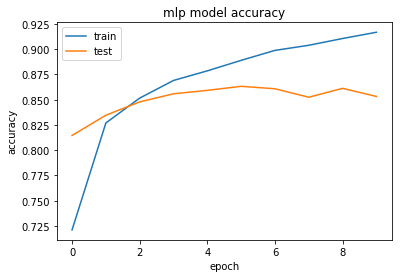

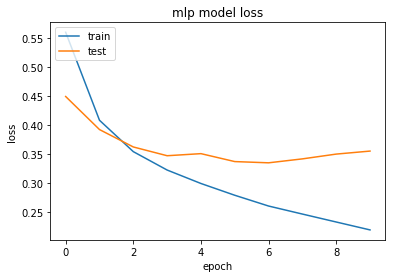

In [53]:
# reference: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('mlp model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('MLP_accuracy.jpg')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('mlp model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('MLP_loss.jpg')
plt.show()

In [45]:
embedded_sequences = embedding_layer(sequence_input)  
l_gru = Bidirectional(LSTM(100, return_sequences=False))(embedded_sequences)  
dense_1 = Dense(100,activation='tanh')(l_gru)  
dense_2 = Dense(2, activation='softmax')(dense_1)  
  
model = Model(sequence_input, dense_2)  
  
model.compile(loss='categorical_crossentropy',  
              optimizer='rmsprop',  
              metrics=['acc'])  
  
model.summary()  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1000, 100)         8150200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_5 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 202       
Total params: 8,331,302
Trainable params: 181,102
Non-trainable params: 8,150,200
_________________________________________________________________


In [46]:
B_LSTM = model.fit(x_train, y_train, validation_data=(x_val, y_val),  
          epochs=10, batch_size=50)

/Users/changlongjiang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1155s 58ms/step - loss: 0.5743 - acc: 0.6964 - val_loss: 0.4224 - val_acc: 0.8118
Epoch 2/10
20000/20000 [==============================] - 1137s 57ms/step - loss: 0.4184 - acc: 0.8118 - val_loss: 0.3699 - val_acc: 0.8396
Epoch 3/10
20000/20000 [==============================] - 1148s 57ms/step - loss: 0.3535 - acc: 0.8471 - val_loss: 0.3556 - val_acc: 0.8466
Epoch 4/10
20000/20000 [==============================] - 1146s 57ms/step - loss: 0.3139 - acc: 0.8669 - val_loss: 0.3075 - val_acc: 0.8692
Epoch 5/10
20000/20000 [==============================] - 1118s 56ms/step - loss: 0.2818 - acc: 0.8825 - val_loss: 0.3217 - val_acc: 0.8654
Epoch 6/10
20000/20000 [==============================] - 1117s 56ms/step - loss: 0.2578 - acc: 0.8933 - val_loss: 0.3061 - val_acc: 0.8860
Epoch 7/10
20000/20000 [==============================] - 1117s 56ms/step - loss: 0.2321 - acc: 0.9054 - val_lo

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


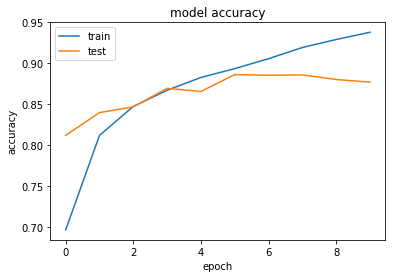

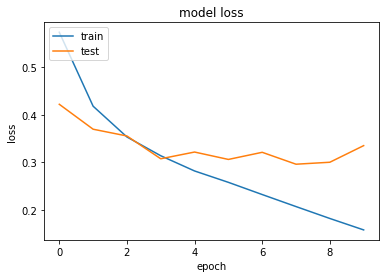

In [49]:
import matplotlib.pyplot as plt
print(B_LSTM.history.keys())
# summarize history for accuracy
plt.plot(B_LSTM.history['acc'])
plt.plot(B_LSTM.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('B_LSTM_accuracy.jpg')
plt.show()
# summarize history for loss
plt.plot(B_LSTM.history['loss'])
plt.plot(B_LSTM.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('B_LSTM_loss.jpg')
plt.show()

$$X^{<1>}$$